# Singular Spectrum Analysis (SSA)
## Задача 20: http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%BF%D1%80%D0%BE%D0%B1%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F
## Steps: https://en.wikipedia.org/wiki/Singular_spectrum_analysis
## Similar: https://github.com/aj-cloete/pySSA

In [158]:
import numpy as np
from numpy import matrix as m
import pandas as pd
from pandas import DataFrame as df

import scipy.linalg
import scipy.io

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

mat = scipy.io.loadmat('C:/Users/valik/Downloads/Data_data.mat')
series = pd.Series(map(lambda x: x[0], mat['Data']))

 ### 'Банановые' данные

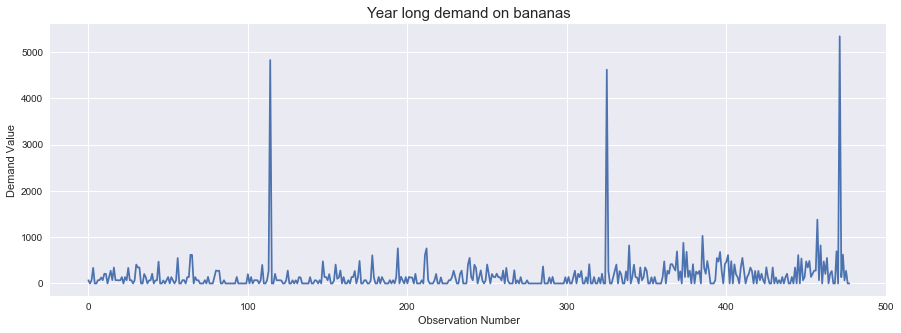

In [9]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax.plot(mat['Data']);
ax.set_title('Year long demand on bananas', fontsize=15);
ax.set_ylabel('Demand Value')
ax.set_xlabel('Observation Number');
ax.grid()

### Декомпозиция исходного временного ряда

$S = X \cdot X^T$

$U, s, V = SVD(S)$

$s := \lambda = \sqrt{s}$

$d = rank X$

$V_i = X^T \cdot U_i / \sqrt{\lambda_i} \hspace{1em} i = (1, \dots, d)$

$X_i = \sqrt{\lambda_i} U_i V_i^T$

$\Rightarrow X = X_1 + \dots + X_d$

In [22]:
period = 30

def Decompose(series, period):
    Hankel = scipy.linalg.hankel(series, np.zeros(period)).T[:, :len(series) - period + 1]

    X = m(Hankel)
    S = X @ X.T
    U, s, V = np.linalg.svd(S, full_matrices=True) 
    U, s, V = m(U), np.sqrt(s), m(V)
    d = np.linalg.matrix_rank(Hankel)

    V_ith, X_ith = [], []
    for i in range(d):
        V_ith.append(X.T * (U[:,i] / s[i]))
        X_ith.append((s[i] * U[:, i]) * (V_ith[i]).T)
        
    return X, U, s, V, X_ith

X, U, s, V, X_ith = Decompose(series, period)

Contributions = np.power(s, 2) / np.linalg.norm(X) ** 2  # contribution of each singular value

### Значимость каждого сингулярного значения

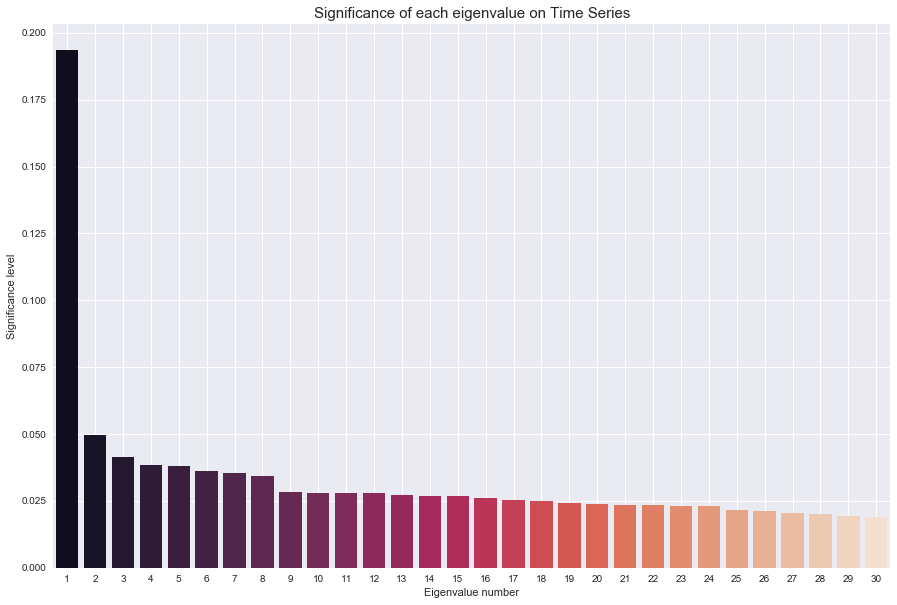

In [11]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10 * 1))

data = Contributions
x = list(range(1, len(data) + 1))
sns.barplot(x, y=data, palette='rocket', ax=ax);  # color=sns.xkcd_rgb['denim blue']
ax.set_title('Significance of each eigenvalue on Time Series', fontsize=15)
ax.set_ylabel('Significance level')
ax.set_xlabel('Eigenvalue number')
ax.grid()
sns.despine(bottom=True, left=True)

# data = np.log(Contributions)
# data = data + max(abs(data))
# data = data / data[0]
# x = list(range(1, len(data) + 1))
# sns.barplot(x, y=data, palette='rocket', ax=ax[1]);  # Blues_r
# ax[1].set_title('Scaled Significance of each eigenvalue on Time Series', fontsize=20)
# ax[1].set_xlabel('Eigenvalue number')
# ax[1].set_ylabel('Scaled Significance level')
# #ax[1].grid()
# sns.despine(bottom=True, left=True)

### Anti-Diagonal Averaging of Hankel Matrix

In [12]:
def AntiDiagonalAveraging(X):
    L, K = X.shape
    minShape, maxShape = min(L, K), max(L, K)

    revived = []

    # Anti Diagonal Averaging
    for k in range(1 - maxShape, minShape):
        # Identity matrix with shifted diagonal to k-th num
        # Rotated clockwise
        # Cut by minShape number of rows
        mask = np.eye(maxShape, k=k, dtype='bool')[::-1][:minShape, :]
        mask_sum = sum(sum(mask))
        masked = np.ma.masked_array(X, mask = 1 - mask)
        revived += [masked.sum() / mask_sum]

    return revived

### Временной ряды, соответствующие самым значимым (top N) сингулярным значениям

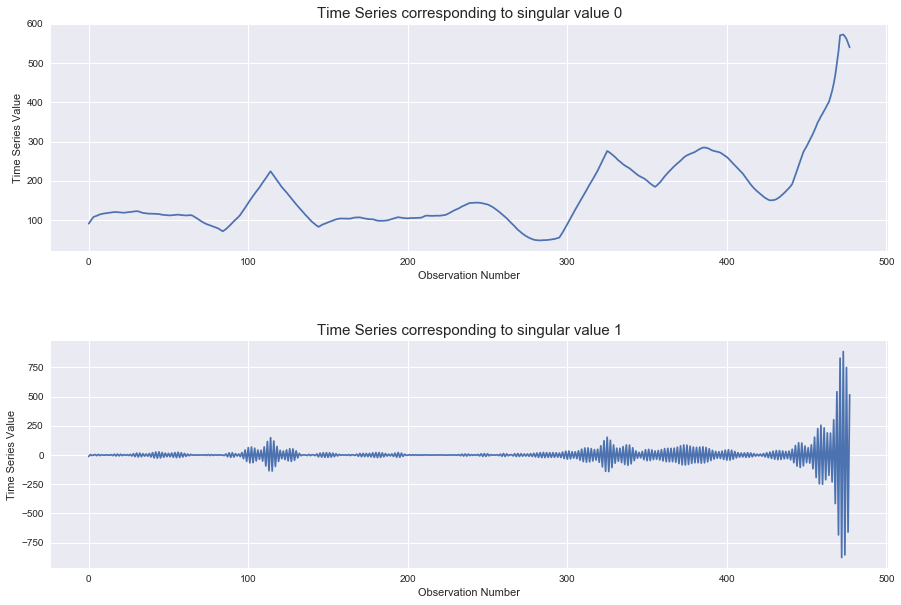

In [13]:
singular_values = 2  # taking top 2 significant singular values

sns.set(style='dark')
fig, ax = plt.subplots(nrows=singular_values, ncols=1, figsize=(15, 5 * singular_values))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # default: 0.2, 0.2

for i in range(singular_values):
    subseries_matrix = X_ith[i]
    subseries = AntiDiagonalAveraging(subseries_matrix)
    if singular_values == 1:
        ax_i = ax
    else:
        ax_i = ax[i]
    ax_i.plot(subseries);
    ax_i.set_title('Time Series corresponding to singular value %d' % (i), fontsize=15);
    ax_i.set_ylabel('Time Series Value');
    ax_i.set_xlabel('Observation Number')
    ax_i.grid()

### Апроксимация исходного временного ряда рядами, соответствующими первым N сингулярным значениям

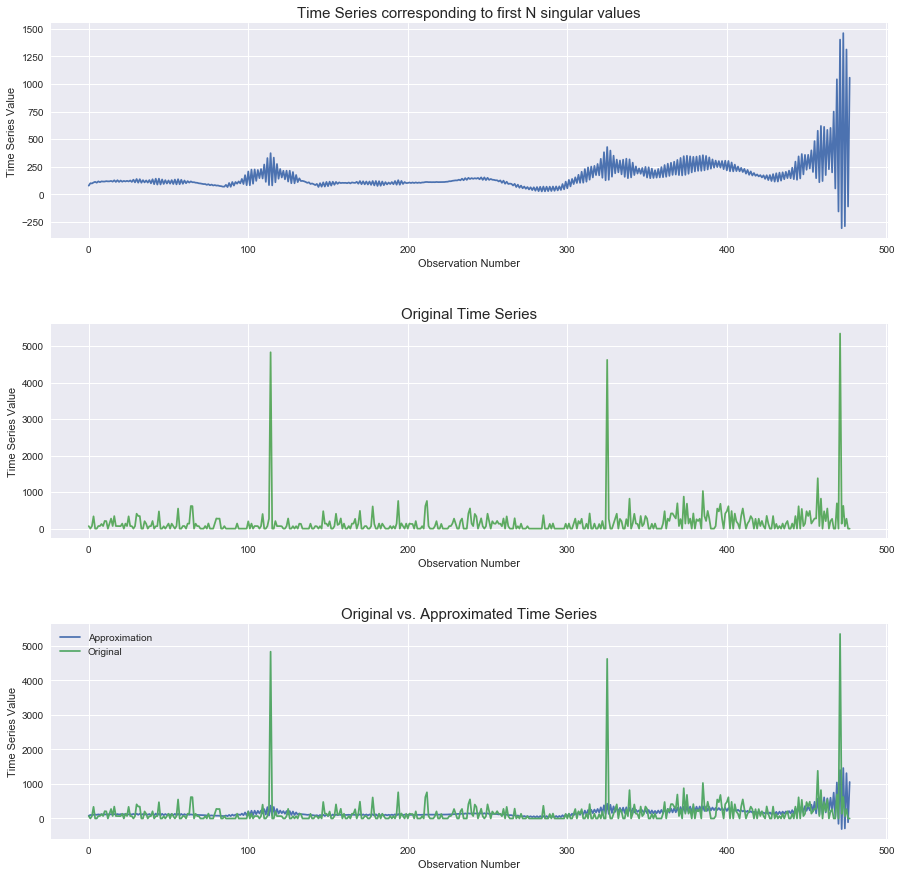

In [14]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 5 * 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # default: 0.2, 0.2

ax[0].plot(AntiDiagonalAveraging(sum([X_ith[i] for i in range(singular_values)])), label='Approximation');
ax[0].set_title('Time Series corresponding to first N singular values', fontsize=15)
ax[0].set_xlabel('Observation Number')
ax[0].set_ylabel('Time Series Value')
ax[0].grid()

ax[1].plot(AntiDiagonalAveraging(X), color='green', alpha=0.6, label='Original');
ax[1].set_title('Original Time Series', fontsize=15)
ax[1].set_xlabel('Observation Number')
ax[1].set_ylabel('Time Series Value')
ax[1].grid()

ax[2].plot(AntiDiagonalAveraging(sum([X_ith[i] for i in range(singular_values)])), label='Approximation');
ax[2].plot(AntiDiagonalAveraging(X), label='Original');
ax[2].legend();
ax[2].set_title('Original vs. Approximated Time Series', fontsize=15)
ax[2].set_xlabel('Observation Number')
ax[2].set_ylabel('Time Series Value');
ax[2].grid()

### Недельное предсказание спроса на бананы

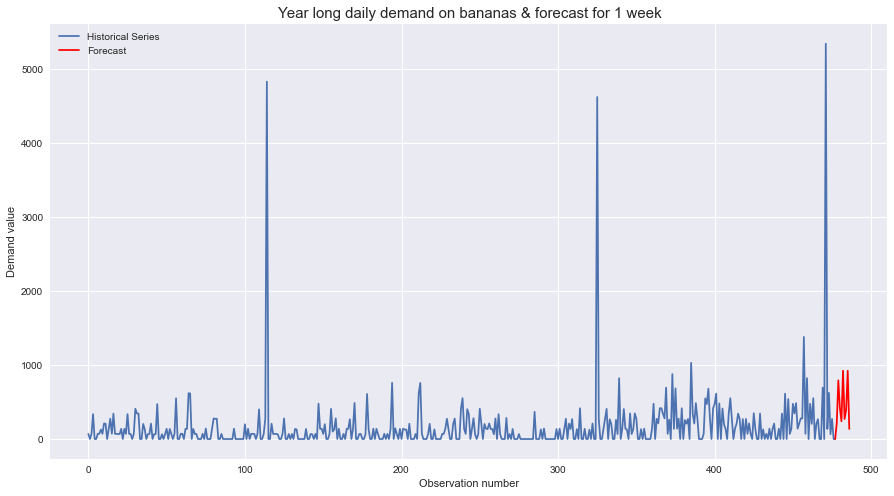

In [92]:
def getForecast(series, predictions, X, U, singular_values, Contributions):
    series_values = series.values
    series_len = series.shape[0]  # TS len

    Orthonormal_base = {i: U[:, i] for i in range(len(Contributions[Contributions > 0]))}  # key i: i-th column of U from SVD
    Forecast_orthonormal_base = {}
    for i in range(singular_values):
        Forecast_orthonormal_base[i] = Orthonormal_base[i]

    X_empty = np.zeros(X.shape)
    verticality_coefficient = 0
    R = np.zeros(Forecast_orthonormal_base[0].shape)[:-1]
    for P in Forecast_orthonormal_base.values():
        X_empty += P * P.T * X
        p = np.ravel(P)[-1]  # transform 1 dim array of 1 elem arrays into 1 dim array and take last value
        verticality_coefficient += p ** 2
        R += p * P[:-1]
    R = m(R / (1 - verticality_coefficient))

    series_forecast = np.ravel(series_values)
    for i in range(series_len, series_len + predictions):
        forecast = R.T * m(series_forecast[max(0, i - R.shape[0]) : i]).T  # need max??
        series_forecast = np.append(series_forecast, forecast[0])
    
    return series_forecast, series_len

# Number of predictions given that our data is 1 year long and we seek to predict 1 week foreward
predictions = int(7 * len(series) / 365)
series_forecast, series_len = getForecast(series, predictions, X, U, singular_values, Contributions)
    
sns.set(style='dark')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.plot(series_forecast[:series_len], label='Historical Series');
ax.plot(range(series_len - 1, len(series_forecast)), series_forecast[series_len - 1:], color='red', label='Forecast');
ax.set_title('Year long daily demand on bananas & forecast for 1 week', fontsize=15)
ax.set_ylabel('Demand value')
ax.set_xlabel('Observation number')
ax.legend();
ax.grid()

# Ошибки

### series = [...................(80%) ....(20%)] 
### Делим данные последовательно на 2 части: 
### Первые 80% - Fit Data и оставкиеся 20% - Test Data.
### Так мы будем определять ошибку на Test Data, прогнозируя ряд по Fit Data, а затем сравнивая результат с последними 20% первоначальных данных 

In [226]:
fit_len = int(8 * len(series) / 10)
test_len = len(series) - fit_len

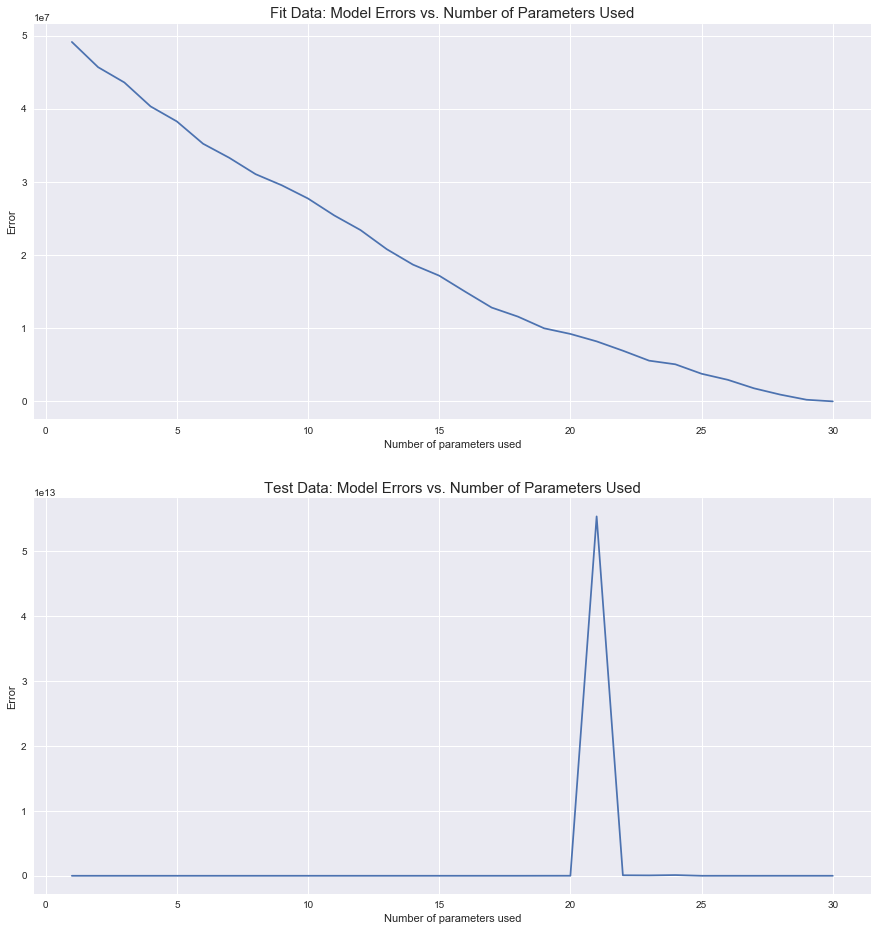

In [227]:
X, U, s, V, X_ith = Decompose(series[:fit_len], period)

#
# Fit period errors
#

fit_errors = []
test_errors = []
for param_num in range(1, period + 1):  # period = len(X_ith)  # param_num = singular_values
    approximation = AntiDiagonalAveraging(sum([X_ith[i] for i in range(param_num)]))
    fit_errors = np.append(fit_errors, (np.cumsum((series[:fit_len] - approximation) ** 2))[-1:].values)
fit_errors = pd.Series(fit_errors)
fit_errors.index = range(1, period + 1)

sns.set(style='dark')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8 * 2))
ax[0].plot(fit_errors, label='Fit Errors');
ax[0].set_title('Fit Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of parameters used')
ax[0].grid()

#
# Test period errors
#

predictions = test_len
Contributions = np.power(s, 2) / np.linalg.norm(X) ** 2  # contribution of each singular value
for singular_values in range(1, period + 1):
    series_forecast, series_len = getForecast(series[:fit_len], predictions, X, U, singular_values, Contributions)
    test_errors = np.append(test_errors, np.cumsum((series[fit_len:] - series_forecast[fit_len:]) ** 2)[-1:].values)
test_errors = pd.Series(test_errors)
test_errors.index = range(1, period + 1)

ax[1].plot(test_errors, label='Test Errors');
ax[1].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Number of parameters used')
ax[1].grid()

### Из-за большой ошибки при 21 аргументе остальные неотличимы. 
### Удалим сначала данные 21 аргумента. 
### Затем данные 19 аргумента и далее.
### После - оставим только ошибки одного, двух и трёх аргументов.

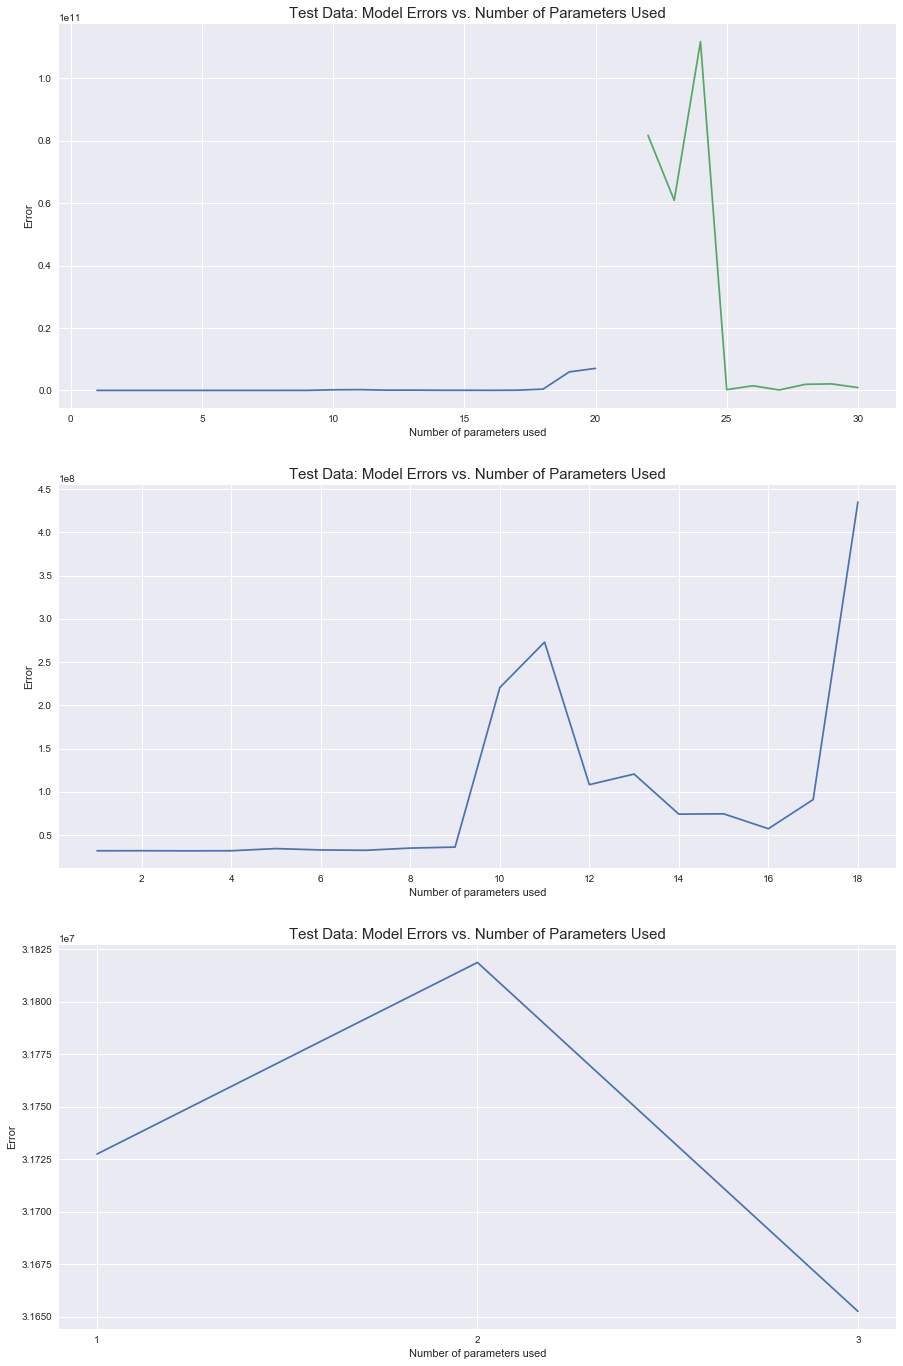

In [228]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 8 * 3))

#
# Test period errors
#

ax[0].plot(test_errors[:20], label='Test Errors');
ax[0].plot(test_errors[21:], label='Test Errors');
ax[0].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of parameters used')
ax[0].grid()

ax[1].plot(list(range(1, len(test_errors[:18]) + 1)), test_errors[:18], label='Test Errors');
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Number of parameters used')
ax[1].grid()

ax[2].plot(list(range(1, len(test_errors[:3]) + 1)), test_errors[:3], label='Test Errors');
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[2].set_ylabel('Error')
ax[2].set_xlabel('Number of parameters used')
ax[2].grid()

### Добавим Стандартные отклонения к ошибкам

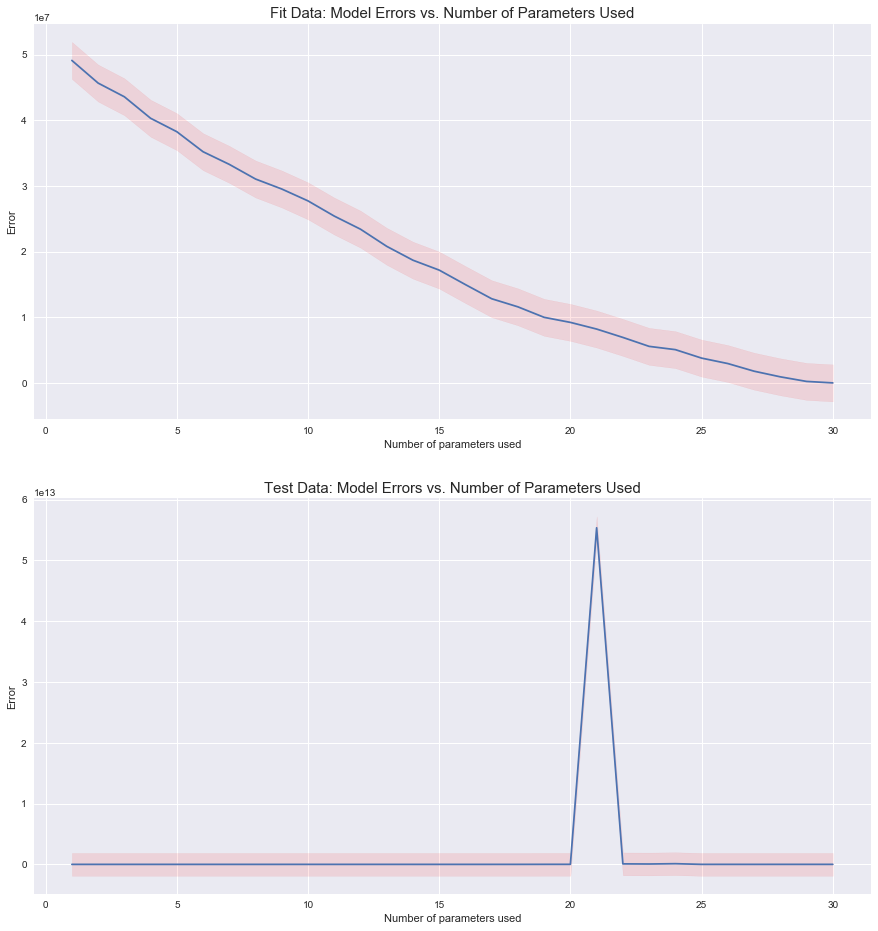

In [229]:
fit_sigma = (np.sqrt((np.cumsum((fit_errors - np.mean(fit_errors)) ** 2))[-1:].values)) / (len(fit_errors) - 1)
test_sigma = (np.sqrt((np.cumsum((test_errors - np.mean(test_errors)) ** 2))[-1:].values)) / (len(test_errors) - 1)

#
# Fit period errors
#

sns.set(style='dark')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8 * 2))
ax[0].plot(fit_errors, label='Fit Errors');
ax[0].fill_between(list(range(1, len(fit_errors) + 1)), fit_errors - fit_sigma,
                     fit_errors + fit_sigma, alpha=0.1,
                     color="r")
ax[0].set_title('Fit Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of parameters used')
ax[0].grid()

#
# Test period errors
#

ax[1].plot(test_errors, label='Test Errors');
ax[1].fill_between(list(range(1, len(test_errors) + 1)), test_errors - test_sigma,
                     test_errors + test_sigma, alpha=0.1,
                     color="r")
ax[1].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Number of parameters used')
ax[1].grid()

### Уберём выброс при количестве аргументов равном 21:
### Пересчитаем стандартное отклонение для значений аргументов до 17, а затем до 3

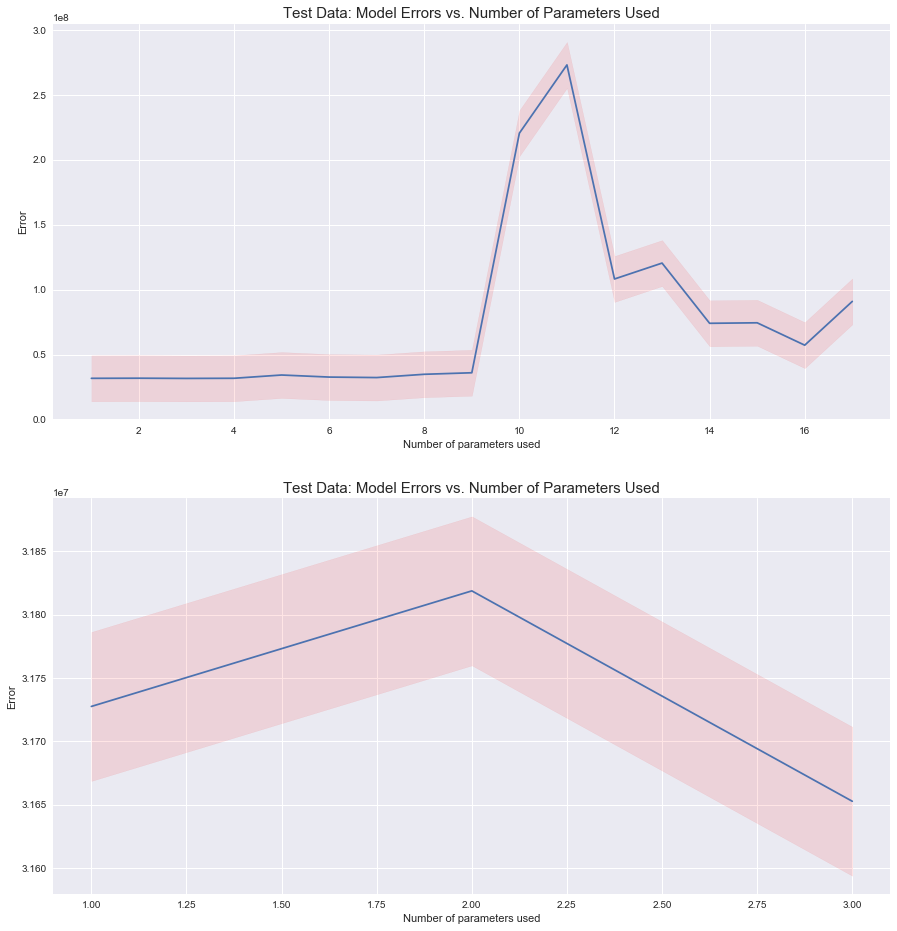

In [230]:
param_limit = 17
test_sigma = (np.sqrt((np.cumsum((test_errors[:param_limit] - np.mean(test_errors[:param_limit])) ** 2))[-1:].values)) / (len(test_errors[:param_limit]) - 1)

#
# Test period errors with number of parameters up to 'param_limit'
#

sns.set(style='dark')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8 * 2))

ax[0].plot(test_errors[:param_limit], label='Test Errors');
ax[0].fill_between(list(range(1, len(test_errors[:param_limit]) + 1)), test_errors[:param_limit] - test_sigma,
                     test_errors[:param_limit] + test_sigma, alpha=0.1,
                     color="r")
ax[0].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of parameters used')
ax[0].grid()

param_limit = 3
test_sigma = (np.sqrt((np.cumsum((test_errors[:param_limit] - np.mean(test_errors[:param_limit])) ** 2))[-1:].values)) / (len(test_errors[:param_limit]) - 1)

ax[1].plot(test_errors[:param_limit], label='Test Errors');
ax[1].fill_between(list(range(1, len(test_errors[:param_limit]) + 1)), test_errors[:param_limit] - test_sigma,
                     test_errors[:param_limit] + test_sigma, alpha=0.1,
                     color="r")
ax[1].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Number of parameters used')
ax[1].grid()

### Картинка к дз: ошибки и стандартные отклонения на Fit & Test данных для количества аргументов до 17 (количество аргументов = сингулярные числа, по котором идёт разложение исходного временного ряда) 

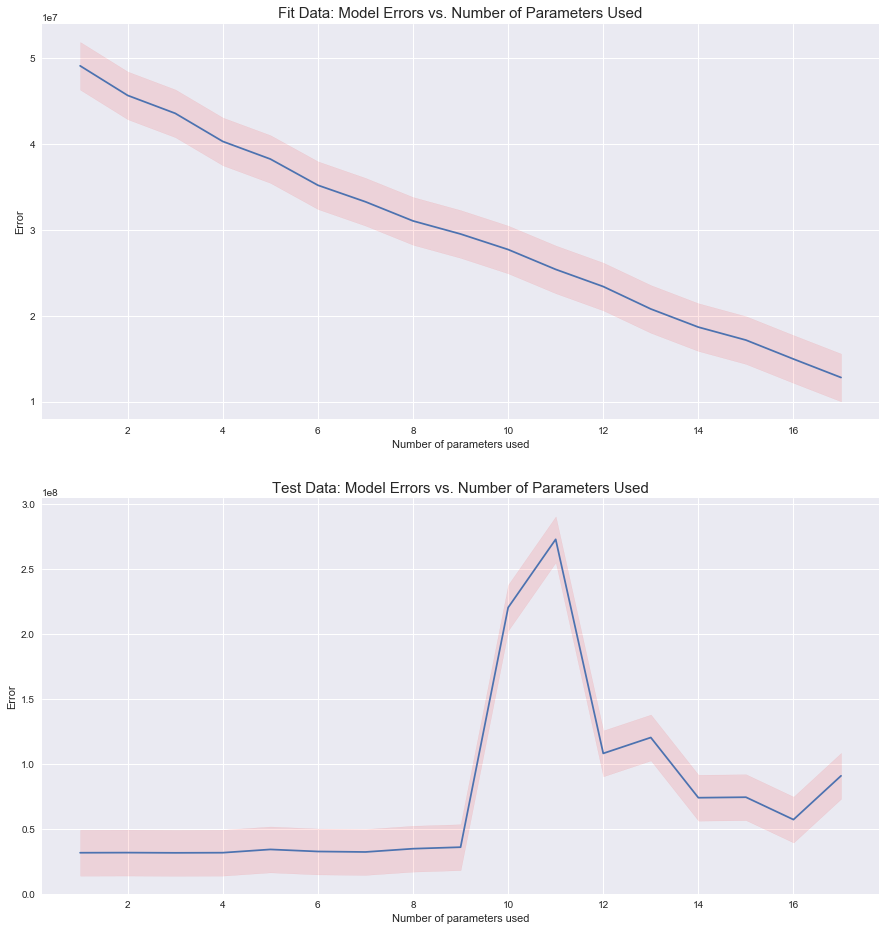

In [232]:
param_limit = 17

fit_sigma = (np.sqrt((np.cumsum((fit_errors[:param_limit] - np.mean(fit_errors[:param_limit])) ** 2))[-1:].values)) / (len(fit_errors[:param_limit]) - 1)
test_sigma = (np.sqrt((np.cumsum((test_errors[:param_limit] - np.mean(test_errors[:param_limit])) ** 2))[-1:].values)) / (len(test_errors[:param_limit]) - 1)

sns.set(style='dark')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8 * 2))

#
# Fit period errors
#

ax[0].plot(fit_errors[:param_limit], label='Fit Errors');
ax[0].fill_between(list(range(1, len(fit_errors[:param_limit]) + 1)), fit_errors[:param_limit] - fit_sigma,
                     fit_errors[:param_limit] + fit_sigma, alpha=0.1,
                     color="r")
ax[0].set_title('Fit Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of parameters used')
ax[0].grid()

#
# Test period errors with number of parameters up to 'param_limit'
#

ax[1].plot(test_errors[:param_limit], label='Test Errors');
ax[1].fill_between(list(range(1, len(test_errors[:param_limit]) + 1)), test_errors[:param_limit] - test_sigma,
                     test_errors[:param_limit] + test_sigma, alpha=0.1,
                     color="r")
ax[1].set_title('Test Data: Model Errors vs. Number of Parameters Used', fontsize=15)
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Number of parameters used')
ax[1].grid()

### Вывод: Ошибки на Fit и Test данных при количестве аргументов менее 10 имеют один и тот же порядок, но их стандартные отклонения существенно отличаются.

In [231]:
fit_sigma = (np.sqrt((np.cumsum((fit_errors[:3] - np.mean(fit_errors[:3])) ** 2))[-1:].values)) / (len(fit_errors[:3]) - 1)
print('Fit & Test sigmas:\n', fit_sigma, test_sigma)
print('\n')
print('Top 5 Fit errors:\n', fit_errors[:10])
print('\n')
print('Top 5 Test errors:\n', test_errors[:10])

Fit & Test sigmas:
 [1976870.51741589] [58786.85902351]


Top 5 Fit errors:
 1     4.913184e+07
2     4.568344e+07
3     4.359588e+07
4     4.032203e+07
5     3.827259e+07
6     3.522061e+07
7     3.329417e+07
8     3.106317e+07
9     2.953984e+07
10    2.773014e+07
dtype: float64


Top 5 Test errors:
 1     3.172748e+07
2     3.181865e+07
3     3.165264e+07
4     3.176193e+07
5     3.427293e+07
6     3.268816e+07
7     3.231346e+07
8     3.483527e+07
9     3.600551e+07
10    2.204906e+08
dtype: float64


 ## Thanks to aj-cloete (GitHub) for similar work on SSA.
 ### Unfortunately his package 'mySSA' didn't work on my data, so I decided to rewrite code specifically to solve this problem.